# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


col_0  count
row_0       
0       5000
1       5000
2       5000
3       5000
4       5000
5       5000
6       5000
7       5000
8       5000
9       5000
0 plane
1 car
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


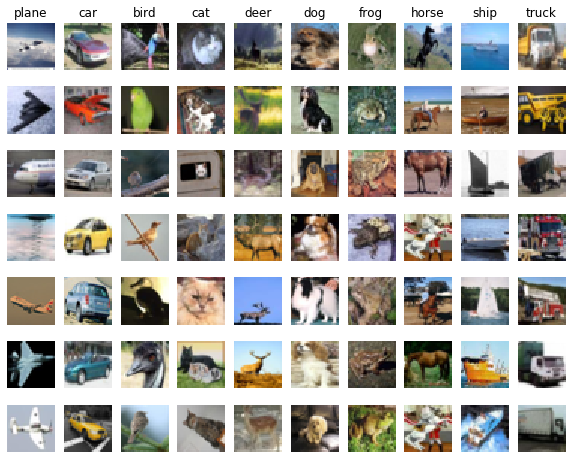

In [68]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

import pandas as pd 
print (pd.crosstab(y_train, columns="count"))
for y, cls in enumerate(classes):
    print (y, cls)
    idxs = np.flatnonzero(y_train == y) #this is a step to give us back the "index" of elements that is not Zero  0 at
    #loop when 
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0 :
            plt.title(cls)
plt.show()

In [3]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]
'''la7z en hena 3aml'''
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [4]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

time take to import data -2.158534288406372
_init_ 3.0994415283203125e-06
train 1.1920928955078125e-06


We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [5]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.
from cs231n.classifiers.k_nearest_neighbor import KNearestNeighbor
# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print ( dists)
print(dists.shape)

Twoloops 123.99513244628906
[[3803.92350081 4210.59603857 5504.0544147  ... 4007.64756434
  4203.28086142 4354.20256764]
 [6336.83367306 5270.28006846 4040.63608854 ... 4829.15334194
  4694.09767687 7768.33347636]
 [5224.83913628 4250.64289255 3773.94581307 ... 3766.81549853
  4464.99921613 6353.57190878]
 ...
 [5366.93534524 5062.8772452  6361.85774755 ... 5126.56824786
  4537.30613911 5920.94156364]
 [3671.92919322 3858.60765044 4846.88157479 ... 3521.04515734
  3182.3673578  4448.65305458]
 [6960.92443573 6083.71366848 6338.13442584 ... 6083.55504619
  4128.24744898 8041.05223214]]
(500, 5000)


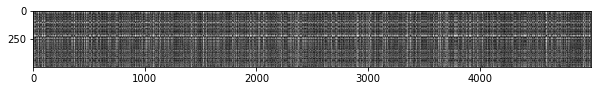

[[3803.92350081 4210.59603857 5504.0544147  ... 4007.64756434
  4203.28086142 4354.20256764]
 [6336.83367306 5270.28006846 4040.63608854 ... 4829.15334194
  4694.09767687 7768.33347636]
 [5224.83913628 4250.64289255 3773.94581307 ... 3766.81549853
  4464.99921613 6353.57190878]
 ...
 [5366.93534524 5062.8772452  6361.85774755 ... 5126.56824786
  4537.30613911 5920.94156364]
 [3671.92919322 3858.60765044 4846.88157479 ... 3521.04515734
  3182.3673578  4448.65305458]
 [6960.92443573 6083.71366848 6338.13442584 ... 6083.55504619
  4128.24744898 8041.05223214]] (500, 5000)


In [81]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()
print ( dists , np.shape(dists))

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ *1- from my point of view, the real cause of white (high distance) in a row is that the Tested data is not fitting any of the trained data
2- coloums is the the distance between one image of the trained and all the tested image, so again when we find white coloum that means that this photo is not like any of the tested, so for this pack of tested images; this training photo was useless*



In [100]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
#H.W:
y_test_pred = classifier.predict_labels(dists, k=1)
#print(pd.crosstab(y_train , columns = ""))
print (np.transpose(y_test_pred))
# Compute and print the fraction of correctly predicted examples
# Remember np.sum is summing True as 1 , while False as 0
num_correct = np.sum(np.transpose(y_test_pred) == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

[[4]
 [9]
 [8]
 [8]
 [4]
 [4]
 [3]
 [2]
 [5]
 [8]
 [2]
 [8]
 [5]
 [7]
 [2]
 [2]
 [5]
 [3]
 [1]
 [4]
 [2]
 [0]
 [0]
 [6]
 [2]
 [4]
 [2]
 [7]
 [2]
 [6]
 [6]
 [2]
 [4]
 [6]
 [8]
 [7]
 [2]
 [8]
 [4]
 [2]
 [8]
 [6]
 [2]
 [4]
 [9]
 [0]
 [5]
 [0]
 [4]
 [2]
 [7]
 [8]
 [4]
 [3]
 [8]
 [8]
 [5]
 [0]
 [0]
 [4]
 [4]
 [6]
 [6]
 [3]
 [3]
 [2]
 [8]
 [8]
 [3]
 [9]
 [2]
 [4]
 [8]
 [0]
 [4]
 [4]
 [6]
 [3]
 [6]
 [8]
 [8]
 [3]
 [5]
 [0]
 [7]
 [4]
 [3]
 [8]
 [8]
 [8]
 [0]
 [4]
 [8]
 [1]
 [4]
 [0]
 [6]
 [0]
 [0]
 [8]
 [4]
 [7]
 [6]
 [4]
 [1]
 [1]
 [4]
 [6]
 [5]
 [5]
 [4]
 [0]
 [3]
 [0]
 [4]
 [4]
 [2]
 [2]
 [4]
 [6]
 [8]
 [4]
 [4]
 [6]
 [8]
 [2]
 [0]
 [2]
 [6]
 [2]
 [2]
 [1]
 [0]
 [6]
 [6]
 [5]
 [9]
 [0]
 [2]
 [8]
 [2]
 [2]
 [6]
 [5]
 [8]
 [4]
 [2]
 [5]
 [5]
 [8]
 [0]
 [3]
 [6]
 [0]
 [8]
 [4]
 [8]
 [8]
 [5]
 [4]
 [0]
 [4]
 [6]
 [4]
 [8]
 [0]
 [8]
 [6]
 [5]
 [0]
 [8]
 [7]
 [8]
 [8]
 [4]
 [4]
 [0]
 [4]
 [4]
 [8]
 [8]
 [0]
 [2]
 [4]
 [0]
 [0]
 [6]
 [3]
 [8]
 [8]
 [3]
 [4]
 [2]
 [2]
 [4]
 [4]
 [8]
 [8]
 [4]
 [2]


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [102]:
y_test_pred = classifier.predict_labels(dists, k=10)
num_correct = np.sum(np.transpose(y_test_pred) == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

[[4.]
 [8.]
 [8.]
 [8.]
 [4.]
 [2.]
 [6.]
 [4.]
 [2.]
 [8.]
 [0.]
 [8.]
 [4.]
 [6.]
 [8.]
 [8.]
 [5.]
 [3.]
 [8.]
 [2.]
 [2.]
 [0.]
 [0.]
 [6.]
 [2.]
 [4.]
 [4.]
 [7.]
 [4.]
 [2.]
 [4.]
 [2.]
 [4.]
 [3.]
 [8.]
 [6.]
 [2.]
 [8.]
 [2.]
 [4.]
 [8.]
 [6.]
 [2.]
 [4.]
 [0.]
 [8.]
 [5.]
 [0.]
 [4.]
 [2.]
 [8.]
 [8.]
 [6.]
 [2.]
 [8.]
 [8.]
 [5.]
 [6.]
 [0.]
 [2.]
 [2.]
 [6.]
 [6.]
 [0.]
 [4.]
 [2.]
 [8.]
 [0.]
 [3.]
 [9.]
 [2.]
 [4.]
 [8.]
 [8.]
 [0.]
 [2.]
 [8.]
 [3.]
 [6.]
 [8.]
 [8.]
 [6.]
 [2.]
 [0.]
 [2.]
 [8.]
 [2.]
 [8.]
 [8.]
 [8.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [4.]
 [0.]
 [0.]
 [4.]
 [4.]
 [4.]
 [3.]
 [3.]
 [4.]
 [8.]
 [4.]
 [6.]
 [5.]
 [5.]
 [4.]
 [0.]
 [6.]
 [2.]
 [4.]
 [4.]
 [0.]
 [4.]
 [4.]
 [4.]
 [8.]
 [4.]
 [2.]
 [2.]
 [8.]
 [4.]
 [8.]
 [6.]
 [4.]
 [2.]
 [2.]
 [8.]
 [8.]
 [6.]
 [2.]
 [2.]
 [9.]
 [0.]
 [2.]
 [8.]
 [2.]
 [8.]
 [0.]
 [2.]
 [8.]
 [0.]
 [6.]
 [2.]
 [5.]
 [5.]
 [0.]
 [3.]
 [0.]
 [8.]
 [4.]
 [4.]
 [0.]
 [8.]
 [5.]
 [4.]
 [0.]
 [2.]
 [2.]
 [4.]
 [8.]
 [0.]
 [8.

You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Explanation:}$
$\color{blue}{\textit Your Answer:}$
1- will not affect on the distance because subtracting all the number with the same number
will result in shifting them all but the distance between them will remain constant.
<br><br>2- will be the same as (1-), as (ith,jth) Pixil will be checked with another (ith,jth) pixil , and both will subtract from them the same number (ith,jth) Mue, so the distance will not change.
<br><br>3- will not affect **the final answer**, because we now will get the **Zscore** for the pixels, by subtract the overall mean from all image at all pixel then divided them the the overall stander daviation, we one are standerdizing it but there will be no change in the final answer, 
for instance, imagine, we have three images have two pixils only each  (2,4) , (4,2) , (6,6) assume that (2,4) was the tested case so distance :
<br> * between it and (4,2) = **4 (minimum)**
<br> * between it and (6,6) = **6** ... 
<br>these number has mean =4 and stander deviation of = Root(3.2) --> Zscore of them is, repectivily, (-1.1,0) , (0,-1.1) , (1.1,1.1) so now we know that (-1.1,0) is the tested case, so distance :
<br> * between it and (0,-1.1)  = **2.2 (minimum)**
<br> * between it and (1.1,1.1) = **3.3  **
<br> 
**notes at the end of the day standerdize them will not affect on any calculations, because dividing by standard deviation is just rescaling as you convert from 1000meter to 1kg, which will not affect on anything**

4- Check the next code **many times** you will find distance ranks changed  after standerdization the for example may coloum 3 be the least distance but after standerdization be not the least but coloum 5 be.

5- No will not change because we just are only changing rotating tested and trained image, but the mechanism are same, the far distance in protrait mode will still be the far distance at the landscape also.






In [63]:
X = np.random.randint(low=0,high=100,size=(100,5))
X_test = np.random.randint (0,100,(100,1))
dist_before = []
dist_after = []
for i in range (X.shape[1]): #number of Colums
    dist_before.append( np.sum( np.abs(X[:,i]- X_test)) )   #L1 distance "minhaten"

#Standerdization
means = np.apply_along_axis(np.mean, 1, X)
Standard_Deviation = np.apply_along_axis(np.std,  1, X)
#by defult the operation of The numby be on Rows so we need to tanspose the X 
X_standerdized = (X.transpose() - means) / Standard_Deviation 
X_standerdized = X_standerdized.transpose() #Transpose it back
X_test_standerdized = (X_test.transpose() - means) / Standard_Deviation 

for i in range (X_standerdized .shape[1]): #number of Colums
    dist_after.append( np.sum( np.abs(X_standerdized [:,i]- X_test_standerdized)) )   #L1 distance "minhaten"
    
print ("Accending Rank for coloums' Distance before standerdization:\n",np.argsort(dist_before)+1)
print ("Accending Rank for coloums' Distance after standerdization:\n",np.argsort(dist_after)+1)

Accending Rank for coloums' Distance before standerdization:
 [2 4 1 3 5]
Accending Rank for coloums' Distance after standerdization:
 [5 2 1 4 3]


In [21]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

time take to import data -5.1975250244140625e-05
_init_ 3.0994415283203125e-06


[autoreload of cs231n.classifiers.k_nearest_neighbor failed: Traceback (most recent call last):
  File "/home/ebrahim/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ebrahim/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/ebrahim/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/ebrahim/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/ebrahim/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/home/ebrahim/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
 

time taken to entre the function 16.406485557556152
Time take to make the matrix is : 0.013752460479736328
Time finish to make the matrix is : 205.55510663986206
oneloops 205.56907558441162
One loop difference was: 0.000000
Good! The distance matrices are the same


In [115]:
classifier.compute_distances_one_loop(X_test)

[[3803.92350081 4210.59603857 5504.0544147  ... 4007.64756434
  4203.28086142 4354.20256764]
 [6336.83367306 5270.28006846 4040.63608854 ... 4829.15334194
  4694.09767687 7768.33347636]
 [5224.83913628 4250.64289255 3773.94581307 ... 3766.81549853
  4464.99921613 6353.57190878]
 ...
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]


array([[3803.92350081, 4210.59603857, 5504.0544147 , ..., 4007.64756434,
        4203.28086142, 4354.20256764],
       [6336.83367306, 5270.28006846, 4040.63608854, ..., 4829.15334194,
        4694.09767687, 7768.33347636],
       [5224.83913628, 4250.64289255, 3773.94581307, ..., 3766.81549853,
        4464.99921613, 6353.57190878],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

In [118]:
dists[1]

array([6336.83367306, 5270.28006846, 4040.63608854, ..., 4829.15334194,
       4694.09767687, 7768.33347636])

In [12]:
dists_two[1]

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

MemoryError: 

In [20]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

time take to import data -4.315376281738281e-05
_init_ 2.1457672119140625e-06
Twoloops 123.92427563667297
Two loop version took 123.924465 seconds
time taken to entre the function 530.7067003250122
Time take to make the matrix is : 0.0057294368743896484
Time finish to make the matrix is : 199.55996966362
oneloops 199.56622576713562
One loop version took 199.566286 seconds


MemoryError: 

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



In [110]:
from scipy import stats
A = np.array(  [[1,2],[10,20]]   )
np.sum(A,1)

array([ 3, 30])